## 台灣股票 技術分析 傅立葉分析 + 線性迴歸

In [1]:
 # 套件引用
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

In [2]:
def get_fft(arr): # 取離散傅立葉轉換 獨立各頻率!! shape [n, n] 對角有值
    n = arr.size
    arrft = np.fft.fft(arr)
    eyeft = np.eye(n) * arrft        
    return eyeft

def get_ifft(eyeft): # 個頻率離散傅立葉逆轉換 變成分散波形 shape [n, n]
    eyeift = np.fft.ifft(eyeft)
    return eyeift

def fft_dict(arr): # 跑完上下兩階 (把'arr' 做離散傅立葉 shape[n, n], out[n]:第'n'筆 頻率'弦波')
    return get_ifft(get_fft(arr))

def lst_sort(arr, n):  # 取得'arr'排序前'n'大的'index'
    return np.argsort(-arr)[0:n] # 排序由小到大 所以加上(-)號 變成由大到小

def get_error(arr1, arr2):  # 'arr1'和'arr2'的誤差估計(d^2)  取正負號 取決於(arr1.mean-arr2.mean)
    c = np.sign(arr1.mean()-arr2.mean()) # np.sign(arr) arr 的正負值 輸出(1, 0, -1)
    return c * ((arr1 - arr2)**2).mean()

def get_linear_regression(arr, s=None): # 產生'arr'的線性回歸, 後面補上's'筆資料
    n = arr.shape[0]
    X = np.vstack((np.ones(n), np.arange(1, n+1))).T
    b = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(arr)
    if s != None:
        X = np.vstack((np.ones(n + s), np.arange(1, n + 1 + s))).T
    outputs = X.dot(b)
    return outputs

def error_val(arr, start, num, test_num, fn, r='y'): # 取得'arr'中用'arr[start:]'用num筆資料, 預測後'test_num'筆資料的誤差, r=='y':加上線性迴歸
    arr = arr[start:start+num+test_num]
    arr = (arr - arr[0:num].mean()) / arr[0:num].std() # 正規化
    reg = get_linear_regression(arr[0:num], test_num) # 取得線性迴歸
    if r == 'y':
        ar = arr - reg
    else:
        ar = arr
    nlst = lst_sort(abs(np.fft.fft(ar[0:num]))[1:(num//2)+1], fn) + 1  # nlst 排序震幅大小  +1 配合fft 的index
    fft = fft_dict(ar[0:num]).real[nlst]*2 # 震幅大到小的傅立葉轉換 因為共厄real值相同 直接 x2
    allfft = fft.sum(0) # 組合全體傅立葉
    allfft = np.append(allfft, allfft[0:test_num]) # 延長傅立葉函數
    if r == 'y':
        allfft = allfft + reg
        plt.plot(reg,  '--g', linewidth=1.5)
    else:
        pass
    for i in range(fn):
        plt.plot(fft[i]+i+2, ':k', linewidth=1.8)
    plt.plot(allfft, 'r')
    plt.plot(arr, 'b')
    #plt.show()
    return get_error(arr[num:], allfft[num:])

def err_lst(arr, start, num, test_num, fn):
    siz = arr[start:].size
    date_siz = siz - test_num - num + 1
    date = np.zeros(date_siz)
    for i in range(date_siz):
        date[i] = error_val(arr, start+i, num, test_num, fn)
    #plt.plot((arr-arr.mean())/arr.std(), 'b')
    #plt.plot(np.append(np.zeros([num+start]), date)/date.max(), 'r')
    #plt.plot(np.zeros_like(arr), '--k')
    return date

'''
up ok
'''
def error_val_reg(arr, start, num, test_num):
    arr = arr[start:start+num+test_num]
    arr = (arr - arr[0:num].mean()) / arr[0:num].std()
    reg = get_linear_regression(arr[0:num], test_num)
    plt.plot(reg)
    plt.plot(arr)
    plt.show()
    return get_error(arr[num:], reg[num:])
# 模擬 隨機性

def rand_normal(size):
    arr = np.random.normal(loc=1, scale=0.0139, size=size)
    ar = np.zeros_like(arr)
    ar[0] = 10.
    for i in range(1, size):
        ar[i] = ar[i-1]*arr[i]
    return ar

def rand_nuifrom(size):
    arr = np.random.uniform(low=0.93, high=1.07, size=size)
    ar = np.zeros_like(arr)
    ar[0] = 10.
    for i in range(1, size):
        ar[i] = ar[i-1]*arr[i]
    return ar

def rand_use_real(size, real_ar):
    arr = np.random.choice(real_ar, size)
    ar = np.zeros_like(arr+1)
    ar[0] = 10.
    for i in range(1, size):
        ar[i] = ar[i-1]*arr[i-1]
    return ar

def get_p(arr):
    ar = np.zeros([arr.size-1])
    for i in range(ar.size):
        ar[i] = arr[i+1]/arr[i]
    return ar


### 讀入資料

In [3]:
TW50 = pd.read_csv('data/TW50.csv').dropna()[-1::-1] # 讀取開盤值 丟棄NAN 值  台灣50
TSMC = pd.read_csv('data/TSMC.csv').dropna()[-1::-1] # 台積電
KS = pd.read_csv('data/KS.csv').dropna()[-1::-1] # 國王滑軌 川湖
FOX = pd.read_csv('data/Foxconn.csv').dropna()[-1::-1] # 鴻海
Largan = pd.read_csv('data/Largan.csv').dropna()[-1::-1] # 大立光
CSC = pd.read_csv('data/CSC.csv').dropna()[-1::-1] # 中鋼
CSSC = pd.read_csv('data/CSSC.csv').dropna()[-1::-1] # 中鋼構 

### 資料範例

In [4]:
TW50[100:110] # (date日期, Open開盤, High最高, Low最低, Close收盤, All總量)

,date,Open,High,Low,Close,All,MA5,MA20,MA60
898,2015/01/29,69.05,69.05,68.15,68.30,19781,29653.8,15201.95,12916.683
897,2015/01/30,68.60,68.60,68.00,68.00,4260,23336.8,15044.2,12635.483
896,2015/02/02,68.20,68.35,67.90,68.15,5805,20407.2,15020.1,12554.8
895,2015/02/03,68.35,68.85,68.10,68.65,16640,16494.4,14877.95,12559.35
894,2015/02/04,69.20,69.50,69.05,69.40,20349,13367,15546.4,12647.05
893,2015/02/05,69.05,69.25,68.80,69.10,4776,10366,15127.85,12413.467
892,2015/02/06,69.10,69.20,68.65,68.75,4100,10334,15038.65,12301.117
891,2015/02/09,68.75,68.75,68.25,68.50,3505,9874,14761.25,12175.317
890,2015/02/10,68.45,68.50,68.20,68.25,8016,8149.2,14854.65,12018.083
889,2015/02/11,68.70,69.25,68.70,69.00,7194,5518.2,14854.3,11972.4


#### 儲存變數 arr1 = 台灣收盤價格

In [5]:
arr1 = TW50['Close'].values
arr2 = TSMC['Close'].values
#arr3 = KS['Close'].values
#arr4 = FOX['Close'].values
#arr5 = Largan['Close'].values
#arr6 = CSC['Close'].values
#arr7 = CSSC['Close'].values

reg = get_linear_regression(arr1) # 台灣50 線性迴歸

#### 線圖 + 線性迴歸

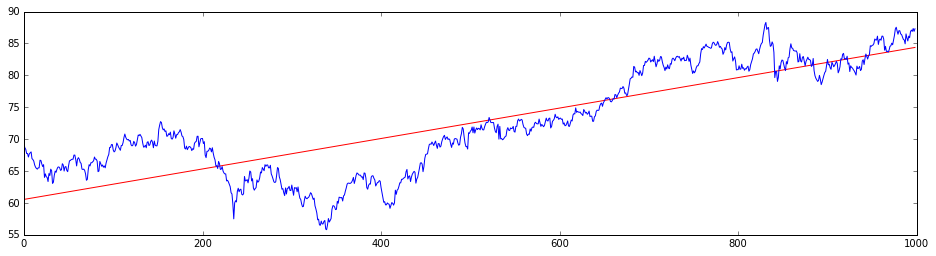

In [6]:
plt.figure(figsize=[16, 4])
plt.plot(reg,'r')
plt.plot(arr1)

#### 把線性迴歸當成基準

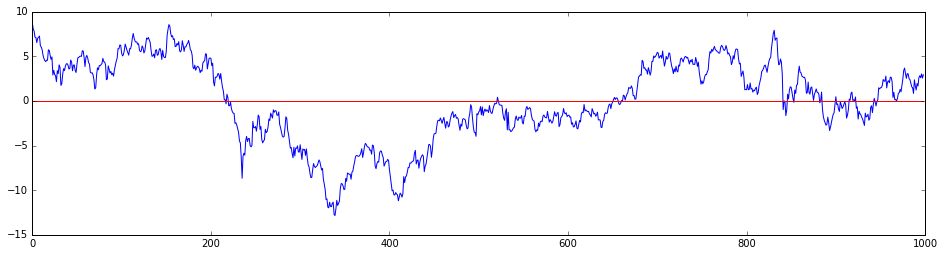

In [7]:
ar = arr1 - reg
plt.figure(figsize=[16, 4])
plt.plot(ar)
plt.plot(reg-reg, 'r')

### 函數 : error_val(arr, start, num, test_num, fn, r='y')  做傅立葉分析 (自動選取震幅大的頻率域排序), 並輸出一判斷數值來分析表現
#### 1. arr : 選用的資料序列
#### 2. start : 要分析的資料(arr) 中範圍起始點
#### 3. num : 需要分析的資料筆數
#### 4. test_num : 預測的資料筆數
#### 5. fn : 需要抓取傅立葉cos波的數量
#### 6. r = 'y' 預設 開啟線性迴歸, other (不開啟)

0.37251760101724374

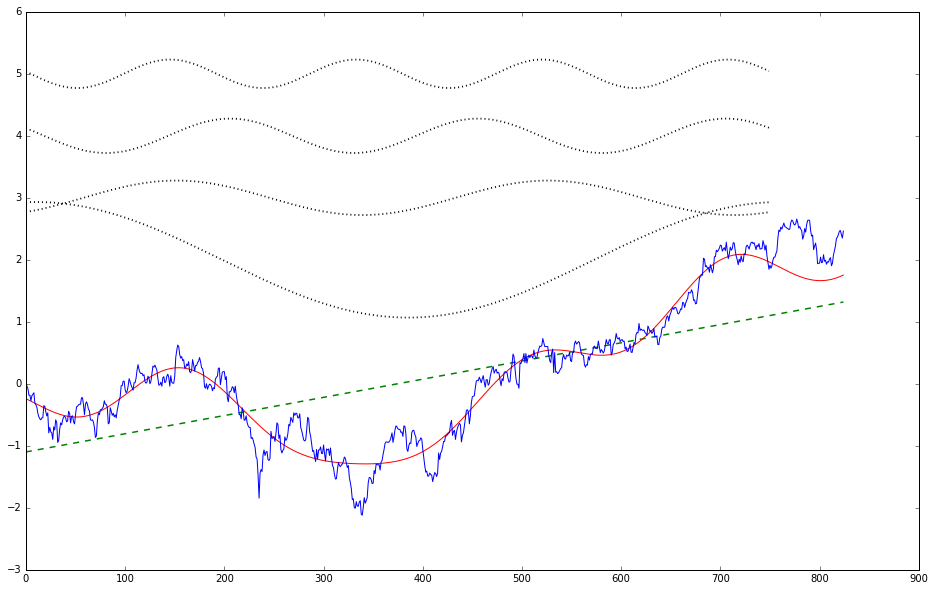

In [8]:
plt.figure(figsize=[16, 10])
error_val(arr1, 0, 750, 75, 4)

In [9]:
plt.figure(figsize=[16, 10])
lst = err_lst(arr4, 0, 100, 10, 2)
lst.mean()

NameError: name 'arr4' is not defined

<Figure size 1152x720 with 0 Axes>

In [ ]:
arr1 = TW50['Open'].values[-1::-1] # 台灣50
arr2 = TSMC['Open'].values[-1::-1] # 台積電
for data_num in range(8, 13):
    for n in range(1, 4):
        a = err_lst(rand1, 0, data_num*10, 25, n).std()
        b = err_lst(rand2, 0, data_num*10, 25, n).std()
        c = err_lst(rand3, 0, data_num*10, 25, n).std()
        print('n=', n, ', data_num=', '%-3d'%(data_num*10),
              ' Rand:', '{:.4f}  {:.4f}  {:.4f}'.format(a, b, c),
              #' TW50_err_val:', '{:.4f}'.format(err_lst(arr1, 0, data_num*10, 25, n).std()),
              #' TSMC_err_val:', '{:.4f}'.format(err_lst(arr2, 0, data_num*10, 25, n).std()),
              #' KS_err_val:', '{:.4f}'.format(err_lst(arr3, 0, data_num*10, 25, n).mean()),
              #' FOX_err_val:', '{:.4f}'.format(err_lst(arr4, 0, data_num*10, 25, n).mean()),
              ' Largan_err_val:', '{:.4f}'.format(err_lst(arr5, 0, data_num*10, 25, n).mean()),
             )
    print('-----------------------------------------------------------------------------------------------')

In [ ]:
ar1 = get_p(arr1)
ar2 = get_p(arr2)
ar3 = get_p(arr3)
ar4 = get_p(arr4)
ar5 = get_p(arr5)
ar6 = get_p(arr6)
ar7 = get_p(arr7)
ar = np.hstack((ar1, ar2, ar3, ar4, ar5, ar6, ar7))
ar.sort()
ar = ar[ar > 0.92]
ar = ar[ar < 1.07]
plt.hist(ar, bins=71, range=(0.93, 1.07))

In [ ]:
rand1 = rand_normal(1000)
rand2 = rand_nuifrom(1000)
rand3 = rand_use_real(1000, ar)

In [ ]:
plt.plot(rand1, 'b')
plt.plot(rand2, 'g')
plt.plot(rand3, 'r')